In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext cython

In [3]:
from PIL import Image

In [4]:
jiang = imageio.imread('images/JZM1962.jpg', pilmode='L')

In [5]:
img = jiang.copy()

In [6]:
toad = imageio.imread('images/toad.jpg', pilmode='L')

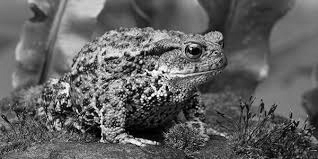

In [7]:
Image.fromarray(toad)

(array([ 2797.,  5170.,  9647., 10627., 11517.,  4556.,  2890.,  2166.,
          872.,   320.]),
 array([  0. ,  25.3,  50.6,  75.9, 101.2, 126.5, 151.8, 177.1, 202.4,
        227.7, 253. ]),
 <a list of 10 Patch objects>)

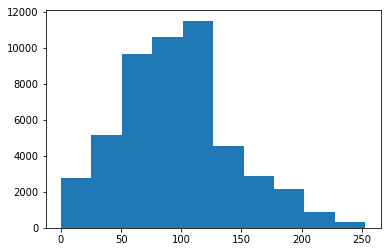

In [8]:
plt.hist(toad.ravel())

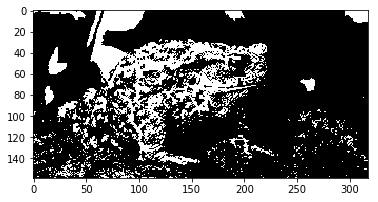

In [9]:
plt.imshow(toad > 128,cmap='gray')

这里我们试试那个生成纹理思路的延伸，虽然感觉更texture modeling，而和MRF好像也没什么关系。首先准备点预备知识，两个正态分布的KL散度为：
$$
\log\left(\frac{\sigma_2}{\sigma_1}\right) + \frac{\sigma_1^2 + (\mu_1-\mu_2)^2}{2\sigma_2^2} - \frac{1}{2}
$$

我们将考虑一些9x9 patch，并计算它们的均值与标准差，直接用一个正态分布建模之（经典的方法当然是直方图，但我就不用），作为那里的“纹理”，然后以一个样本纹理（图中央长者背上某块区域）与其比对，我们先看看这样能产生什么样的"feature map"

In [10]:
def kl_normal(mu1, sd1, mu2, sd2):
    return np.log(sd2) - np.log(sd1) + (sd1**2 + (mu1-mu2)**2)/(2*sd2**2) - 0.5

In [11]:
windows_size = 9
toad_padded = np.pad(toad, windows_size//2, 'reflect')

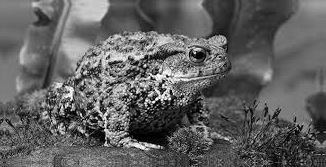

In [12]:
Image.fromarray(toad_padded)

In [13]:
a = np.arange(10)
a_strided = np.lib.stride_tricks.as_strided(
    a, shape=(8, 3), strides=(4, 4)
)
print(np.mean(a_strided, axis=1))


[1. 2. 3. 4. 5. 6. 7. 8.]


In [14]:
a_strided

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])

In [15]:
a.dtype

dtype('int32')

In [16]:
toad_padded.dtype

dtype('uint8')

In [17]:
s1,s2 = toad_padded.strides
toad_patch = np.lib.stride_tricks.as_strided(
    toad_padded, 
    shape = (toad.shape[0], toad.shape[1], windows_size, windows_size),
    strides = (s1, s2, s1, s2)
)

In [18]:
toad_patch[0,0]

array([[125, 125, 126, 126, 126, 126, 126, 125, 125],
       [126, 127, 127, 127, 128, 127, 127, 127, 126],
       [128, 128, 128, 129, 129, 129, 128, 128, 128],
       [129, 129, 129, 130, 130, 130, 129, 129, 129],
       [128, 129, 129, 129, 129, 129, 129, 129, 128],
       [129, 129, 129, 130, 130, 130, 129, 129, 129],
       [128, 128, 128, 129, 129, 129, 128, 128, 128],
       [126, 127, 127, 127, 128, 127, 127, 127, 126],
       [125, 125, 126, 126, 126, 126, 126, 125, 125]], dtype=uint8)

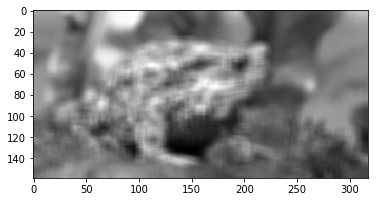

In [19]:
plt.imshow(np.mean(toad_patch, axis=(2,3)), cmap='gray')
plt.show()

In [20]:
mean = toad_patch.mean(axis=(2,3))
sd = toad_patch.std(axis=(2,3))

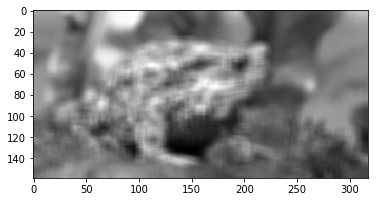

In [21]:
plt.imshow(mean, cmap='gray')
plt.show()

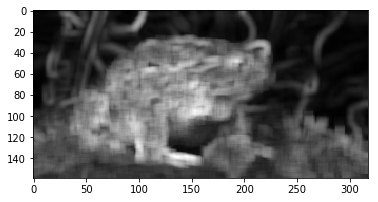

In [22]:
plt.imshow(sd, cmap='gray')
plt.show()

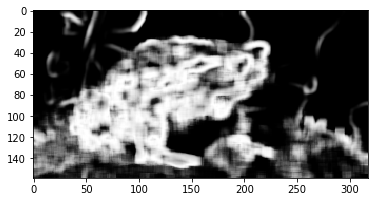

In [23]:
plt.imshow(np.exp(-kl_normal(mean[100,100],sd[100,100],mean,sd)),cmap='gray')
plt.show()

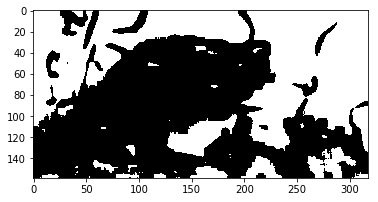

In [24]:
plt.imshow(kl_normal(mean[100,100],sd[100,100],mean,sd) > 3, cmap='gray')

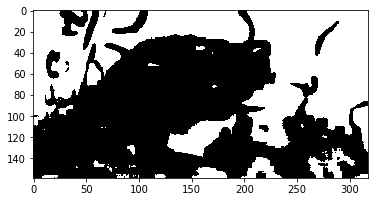

In [25]:
plt.imshow(kl_normal(mean[100,100],sd[100,100],mean,sd) > 3.5, cmap='gray')

多元正态分布的KL散度

Ref:
* https://stats.stackexchange.com/questions/60680/kl-divergence-between-two-multivariate-gaussians
* http://stanford.edu/~jduchi/projects/general_notes.pdf

$$
\frac{1}{2}\left[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + Tr(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)\right]
$$

为$d$维正态分布的KL散度。

In [53]:
def kl_normal_multi(mu1,sigma1,mu2,sigma2,d=3):
    d = mu1.shape[0]
    det = np.linalg.det
    log = np.log
    trace = np.trace
    log = np.log
    inv = np.linalg.inv
    
    inv_sigma2 = inv(sigma2)
    diff = mu2 - mu1
    diff_L = np.expand_dims(diff, 2)
    diff_R = np.expand_dims(diff, 3)
    right = (diff_L @ inv_sigma2 @ diff_R).squeeze()
    dis = log(det(sigma2)) - log(det(sigma1)) - d + trace(inv_sigma2 @ sigma1, axis1=2, axis2=3) + right
    return 0.5 * dis
    

In [27]:
toad_rgb = imageio.imread('images/toad.jpg')

In [28]:
windows_size = 9
r,g,b = toad_rgb[:,:,0],toad_rgb[:,:,1],toad_rgb[:,:,2]
toad_rgb_padded = np.stack([np.pad(mat, (windows_size//2), 'reflect') for mat in [r,g,b]])
toad_rgb_padded = np.transpose(toad_rgb_padded, (1,2,0))
toad_rgb.shape, toad_rgb_padded.shape

((159, 318, 3), (167, 326, 3))

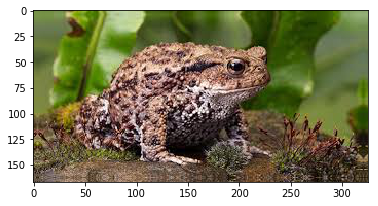

In [29]:
plt.imshow(toad_rgb_padded)

In [30]:
toad_rgb_padded.strides

(326, 1, 54442)

In [31]:
toad_rgb_padded.copy().strides

(978, 3, 1)

In [32]:
toad_rgb_padded = toad_rgb_padded.copy()
toad_rgb_padded.strides

(978, 3, 1)

In [33]:
s1,s2,s3 = toad_rgb_padded.strides
toad_rgb_patch = np.lib.stride_tricks.as_strided(
    toad_rgb_padded,
    shape = (toad_rgb.shape[0], toad_rgb.shape[1], windows_size, windows_size, toad_rgb.shape[2]),
    strides = (s1, s2, s1, s2, s3)
)

In [34]:
toad_rgb_patch.shape

(159, 318, 9, 9, 3)

In [35]:
toad_rgb_patch[0,0,0,0]

array([115, 141,  70], dtype=uint8)

In [36]:
toad_rgb_patch[0,0].shape

(9, 9, 3)

In [37]:
mean_mult = toad_rgb_patch.mean(axis=(2,3),keepdims=True)
#cov_mult = np.cov(toad_rgb_patch.reshape(toad_rgb.shape[0], toad_rgb.shape[1], -1 ,toad_rgb.shape[2]), axis=2) 

In [38]:
mean_mult.shape

(159, 318, 1, 1, 3)

In [39]:
toad_rgb_patch_centered = toad_rgb_patch - mean_mult

In [40]:
toad_rgb_flatten = toad_rgb_patch_centered.reshape(toad_rgb.shape[0], toad_rgb.shape[1], -1, toad_rgb.shape[2])
toad_rgb_flatten.shape

(159, 318, 81, 3)

In [41]:
cov_mult = (toad_rgb_flatten.transpose(0,1,3,2) @ toad_rgb_flatten)/(windows_size**2-1)

In [42]:
np.cov(toad_rgb_patch[0,0].reshape( -1, toad_rgb.shape[2]).T)

array([[1.775, 2.425, 0.475],
       [2.425, 3.775, 0.425],
       [0.475, 0.425, 0.55 ]])

In [43]:
cov_mult[0,0]

array([[1.775, 2.425, 0.475],
       [2.425, 3.775, 0.425],
       [0.475, 0.425, 0.55 ]])

In [63]:
#kl_normal_multi(mean_mult[100,100,0,0,:], cov_mult[100,100,:], mean_mult[:,:,0,0,:], cov_mult)
#LinAlgError: Singular matrix
kl_normal_multi_dis = kl_normal_multi(mean_mult[100,100,0,0,:], cov_mult[100,100,:] + np.eye(3), mean_mult[:,:,0,0,:], cov_mult + np.eye(3))

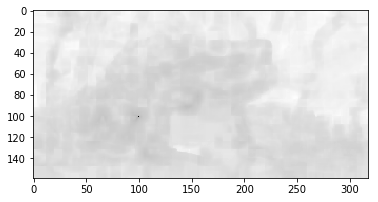

In [65]:
plt.imshow(np.log(kl_normal_multi_dis), cmap='gray')

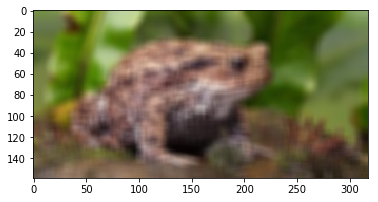

In [73]:
plt.imshow(mean_mult.squeeze().astype(np.int))

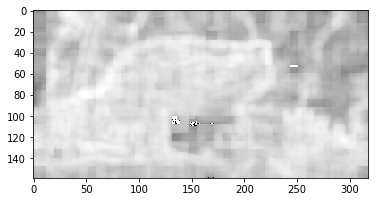

In [76]:
plt.imshow(np.log(np.linalg.det(cov_mult)),cmap='gray')

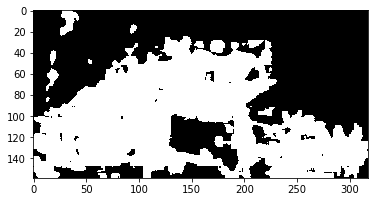

In [88]:
plt.imshow(kl_normal_multi_dis < 30, cmap='gray')